# Example 1: A classical symmetry Mpemba Effect with Z_4

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

np.set_printoptions(precision=2, suppress=True)

# Generator for 4-site ring Markov chain
ε = .25 # chirality parameter
L = np.array([
    [-2, 1 + ε, 0, 1 - ε],
    [1 - ε, -2, 1 + ε, 0],
    [0, 1 - ε, -2, 1 + ε],
    [1 + ε, 0, 1 - ε, -2]
])

t = np.exp(2*np.pi * 1j / 4)  # rotation factor for the eigenvectors
r1, r2, r3, r4 = [np.array([1, t**(mu), t**(2*mu), t**(3*mu)]) / 2 for mu in [0, 1, 3, 2]]
l1, l2, l3, l4 = 0, -2 + 2j * ε, -2 - 2j * ε, -4

# assert that the evals and evecs are correct with the eval equation
for i, (l, r) in enumerate(zip([l1, l2, l3, l4], [r1, r2, r3, r4])):
    print(L.shape, r.shape)
    assert np.allclose(l * r, L @ r), f"Eigenvalue {i} does not satisfy the eigenvalue equation: {l} * {r} != {L @ r}"

p1 = r1/2 + r4/2
p2 = r1/2 + r2/4 + r3/4

print(f"p1: {p1},\np2: {p2}")
# Check that p1, p2 are valid probability distributions (real, non-negative, sum to 1)
for name, p in zip(['p1', 'p2'], [p1, p2]):
    assert np.allclose(p.imag, 0), f"{name} has non-zero imaginary part"
    assert np.isclose(np.sum(p.real), 1), f"{name} does not sum to one: {np.sum(p.real)}"
    assert (p.real >= 0).all(), f"{name} has negative entries: {p.real}"

(4, 4) (4,)
(4, 4) (4,)
(4, 4) (4,)
(4, 4) (4,)
p1: [0.5+0.j 0. +0.j 0.5-0.j 0. +0.j],
p2: [0.5 +0.j 0.25+0.j 0.  +0.j 0.25+0.j]


In [2]:
# Symmetry measure
def M(p):
    p = np.real_if_close(p)        # remove tiny imag parts
    p = np.clip(p, 1e-16, None)    # floor to avoid log of zero/negatives
    return np.sum(p * np.log(4 * p))

# Time grid
t = np.linspace(0, 1, 300)

# Numerical M
M1_num = [M(expm(L * ti).dot(p1)) for ti in t]
M2_num = [M(expm(L * ti).dot(p2)) for ti in t]

# Analytical time evolution
p1_ana = np.array([(r1 + np.exp(l4 * ti) * r4) / 2 for ti in t])
p2_ana = np.array([(r1 + np.exp(l2 * ti) * r2 / 2 + np.exp(l3 * ti) * r3 / 2) / 2 for ti in t])
M1_ana = np.array([np.exp(-8 * ti) for ti in t])/2 #[M(p) for p in p1_ana]
M2_ana = np.array([np.exp(-4 * ti) for ti in t])/4 #[[M(p) for p in p2_ana]

In [3]:
# Find the crossing point between M1_num and M2_num

diff = np.array(M1_num) - np.array(M2_num)
sign_change = np.where(np.diff(np.sign(diff)))[0]

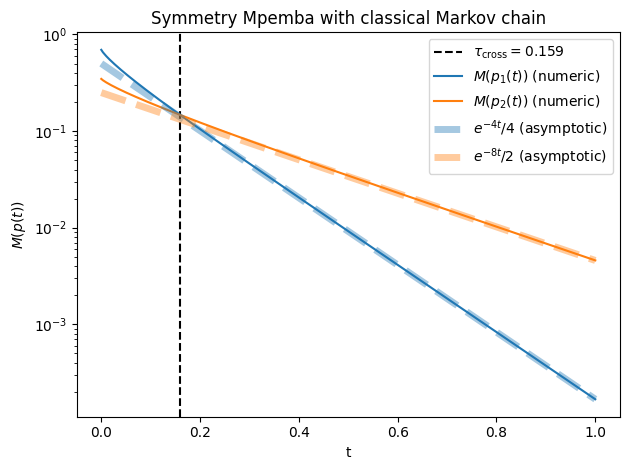

In [4]:
# Plot
if len(sign_change) > 0:
    i = sign_change[0]
    f = interp1d(diff[i:i+2], t[i:i+2])
    t_cross = float(f(0))
    plt.axvline(t_cross, color='k', linestyle='--', label=fr'$\tau_{{\rm cross}}={t_cross:.3f}$')
else:
    t_cross = None
    
plt.plot(t, M1_num, label=r'$M(p_1(t))$ (numeric)', color='C0')
plt.plot(t, M2_num, label=r'$M(p_2(t))$ (numeric)', color='C1')
    
plt.plot(t, M1_ana, ls='--', label=r'$e^{-4t}/4$ (asymptotic)', c='C0', lw = 5, alpha=0.4)
plt.plot(t, M2_ana, ls='--', label=r'$e^{-8t}/2$ (asymptotic)', c='C1', lw = 5, alpha=0.4)
plt.xlabel('t')
plt.ylabel(r'$M(p(t))$')
plt.title('Symmetry Mpemba with classical Markov chain')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

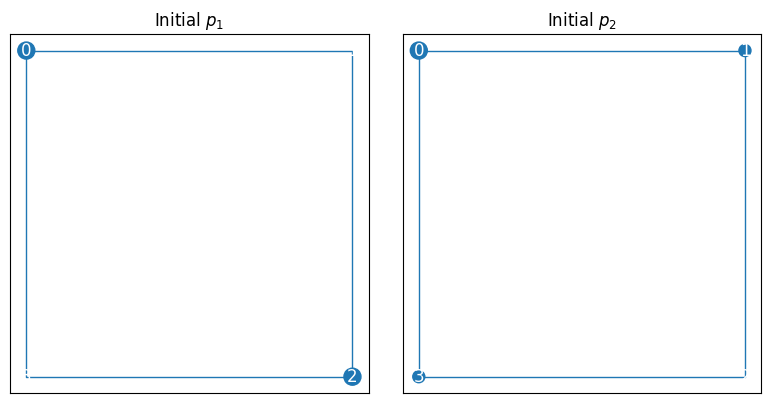

In [5]:
# Define node positions on a square
positions = np.array([
    [0, 1],  # site 0
    [1, 1],  # site 1
    [1, 0],  # site 2
    [0, 0]   # site 3
])

p1 = np.real_if_close(p1)
p2 = np.real_if_close(p2)

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, p, title in zip(axes, [p1, p2], ['Initial $p_1$', 'Initial $p_2$']):
    # Draw square edges
    square = np.vstack([positions, positions[0]])
    ax.plot(square[:, 0], square[:, 1], linestyle='-', linewidth=1)
    
    # Scatter nodes with size proportional to probability
    sizes = 300 * p
    ax.scatter(positions[:, 0], positions[:, 1], s=sizes)
    
    # Label nodes
    for idx, (x, y) in enumerate(positions):
        ax.text(x, y, f'{idx}', ha='center', va='center', color='white', fontsize=12)
    
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plt.tight_layout()
plt.show()
